# Reinforcement Learning: Zero to Hero - Part 2/17

**Cells 21-40 of 291**



#### Comparing Greedy vs Epsilon-Greedy Performance

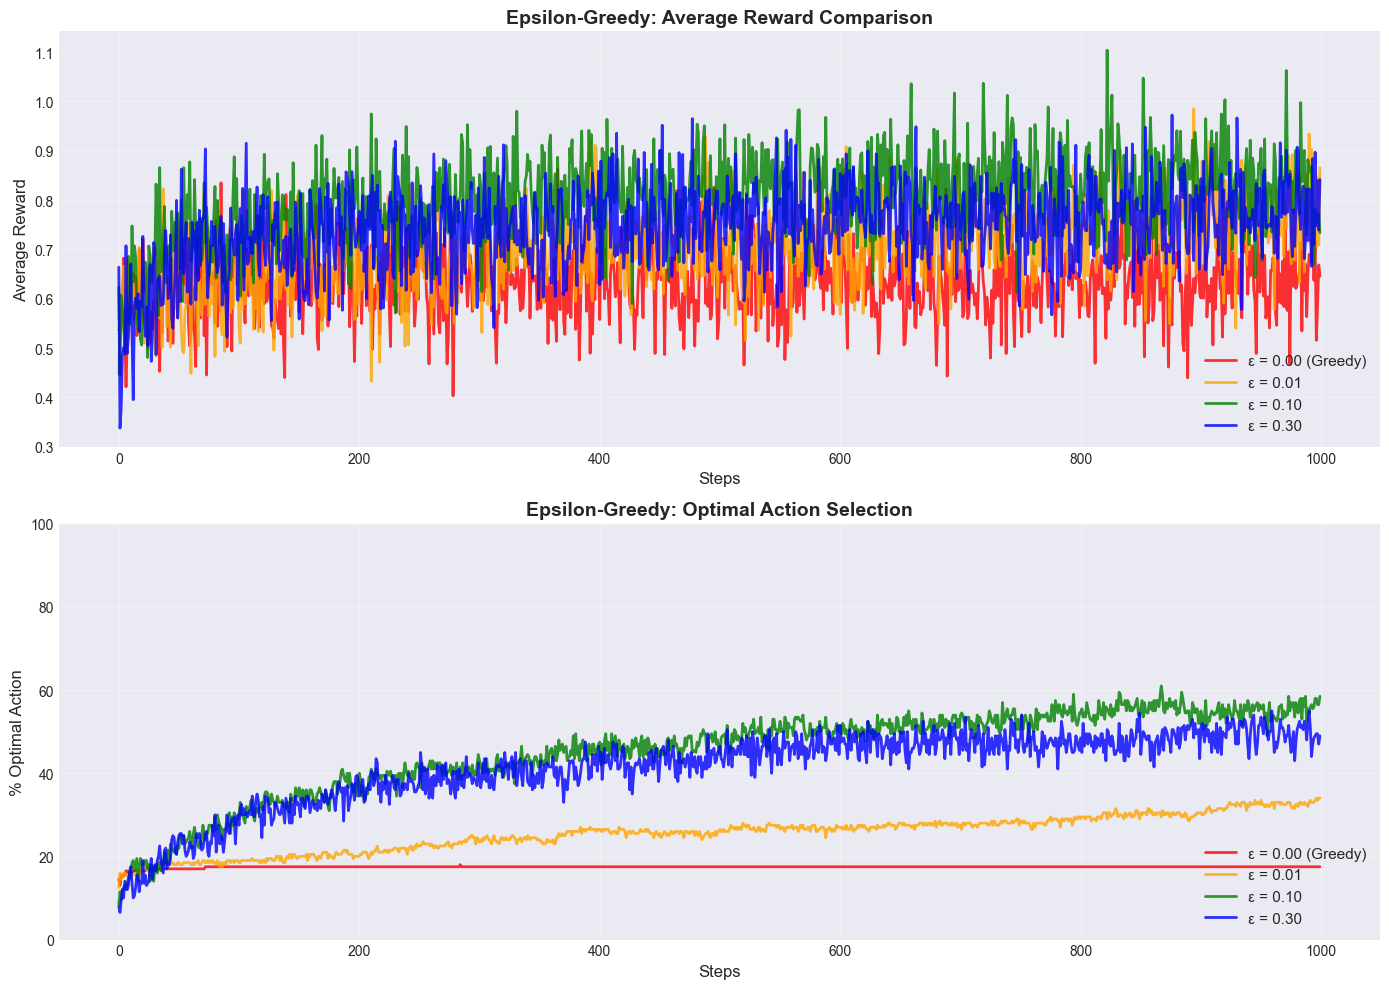

📊 Performance Summary (averaged over 200 experiments):
Strategy             Avg Reward      Optimal %       Final Optimal %
ε = 0.00 (Greedy)    0.634           17.4            17.5%
ε = 0.01             0.701           25.5            32.3%
ε = 0.10             0.803           45.1            55.0%
ε = 0.30             0.742           41.3            49.7%
✅ Conclusions:
   1. Greedy (ε=0) performs poorly due to lack of exploration
   2. Small epsilon (0.01-0.1) achieves good balance
   3. ε=0.1 typically performs best in this setting
   4. Too much exploration (ε=0.3) wastes opportunities to exploit
   5. Epsilon-greedy successfully solves the exploration-exploitation dilemma!


In [10]:
# Run comprehensive comparison across multiple experiments
num_experiments = 200
steps = 1000
epsilon_values = [0.0, 0.01, 0.1, 0.3]

# Store results for each epsilon value
all_results = {eps: {'rewards': [], 'optimal': []} for eps in epsilon_values}

np.random.seed(42)
for i in range(num_experiments):
    bandit = MultiArmedBandit(k=10)
    
    for eps in epsilon_values:
        agent = EpsilonGreedyAgent(k=10, epsilon=eps)
        rewards, optimal = run_experiment(agent, bandit, steps)
        all_results[eps]['rewards'].append(rewards)
        all_results[eps]['optimal'].append(optimal)

# Calculate averages
avg_results = {}
for eps in epsilon_values:
    avg_results[eps] = {
        'rewards': np.mean(all_results[eps]['rewards'], axis=0),
        'optimal': np.mean(all_results[eps]['optimal'], axis=0)
    }

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

colors = ['red', 'orange', 'green', 'blue']
labels = [f'ε = {eps:.2f}' + (' (Greedy)' if eps == 0 else '') for eps in epsilon_values]

# Plot 1: Average reward over time
for eps, color, label in zip(epsilon_values, colors, labels):
    ax1.plot(avg_results[eps]['rewards'], linewidth=2, color=color, alpha=0.8, label=label)

ax1.set_xlabel('Steps', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('Epsilon-Greedy: Average Reward Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Percentage of optimal actions
for eps, color, label in zip(epsilon_values, colors, labels):
    ax2.plot(avg_results[eps]['optimal'] * 100, linewidth=2, color=color, alpha=0.8, label=label)

ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('% Optimal Action', fontsize=12)
ax2.set_title('Epsilon-Greedy: Optimal Action Selection', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 Performance Summary (averaged over {} experiments):".format(num_experiments))
print("="*70)
print(f"{'Strategy':<20} {'Avg Reward':<15} {'Optimal %':<15} {'Final Optimal %'}")
print("="*70)

for eps in epsilon_values:
    strategy = f"ε = {eps:.2f}" + (" (Greedy)" if eps == 0 else "")
    avg_reward = np.mean(avg_results[eps]['rewards'])
    avg_optimal = np.mean(avg_results[eps]['optimal']) * 100
    final_optimal = np.mean(avg_results[eps]['optimal'][-100:]) * 100  # Last 100 steps
    
    print(f"{strategy:<20} {avg_reward:<15.3f} {avg_optimal:<15.1f} {final_optimal:.1f}%")

print("="*70)
print("✅ Conclusions:")
print("   1. Greedy (ε=0) performs poorly due to lack of exploration")
print("   2. Small epsilon (0.01-0.1) achieves good balance")
print("   3. ε=0.1 typically performs best in this setting")
print("   4. Too much exploration (ε=0.3) wastes opportunities to exploit")
print("   5. Epsilon-greedy successfully solves the exploration-exploitation dilemma!")

#### Optimistic Initial Values: Exploration Through Disappointment

**A Clever Alternative to Epsilon-Greedy**

The Optimistic Initial Values approach provides a different solution to encourage exploration. Instead of randomly exploring, it uses **disappointment-driven exploration**.

**The Key Idea:**

Initialize all action-value estimates to be **optimistically high** (higher than any realistic reward). When the agent tries an action and receives a lower-than-expected reward, it becomes "disappointed" and tries other actions, naturally encouraging exploration.

**How It Works:**

1. Set initial Q-values to a high value (e.g., +5 when true rewards are around 0-1)
2. Use a greedy strategy (no epsilon needed!)
3. Each action will initially seem promising
4. After trying an action, its estimate decreases toward the true value
5. The agent naturally tries all actions before settling on the best one

**Mathematical Intuition:**

If we initialize $Q_0(a) = c$ for all actions where $c$ is large:

$$Q_{n+1}(a) = Q_n(a) + \frac{1}{n+1}(R_n - Q_n(a))$$

Since $R_n < Q_n(a)$ initially, the estimate decreases, making other untried actions more attractive.

**Advantages:**
- No need to tune an epsilon parameter
- Exploration happens naturally through the learning process
- Simple to implement
- Works well for stationary problems

**Disadvantages:**
- Only explores at the beginning (not suitable for non-stationary problems)
- Requires knowing a good initial value
- Less flexible than epsilon-greedy

Let's implement and compare this approach:

In [11]:
class OptimisticGreedyAgent:
    """A greedy agent with optimistic initial value estimates."""
    
    def __init__(self, k, initial_value=5.0):
        """Initialize the agent with optimistic values.
        
        Args:
            k: Number of arms
            initial_value: Optimistic initial estimate for all actions
        """
        self.k = k
        self.initial_value = initial_value
        # Initialize all estimates optimistically
        self.q_estimates = np.ones(k) * initial_value
        self.action_counts = np.zeros(k)
        
    def select_action(self):
        """Select action greedily (highest estimated value)."""
        max_value = np.max(self.q_estimates)
        best_arms = np.where(self.q_estimates == max_value)[0]
        return np.random.choice(best_arms)
    
    def update(self, action, reward):
        """Update estimates after receiving a reward."""
        self.action_counts[action] += 1
        n = self.action_counts[action]
        
        # Incremental update
        self.q_estimates[action] += (1/n) * (reward - self.q_estimates[action])


# Demonstrate optimistic initial values
print("Optimistic Initial Values Demonstration")
print("="*60)

np.random.seed(42)
bandit = MultiArmedBandit(k=10)

print(f"True reward range: [{bandit.true_means.min():.2f}, {bandit.true_means.max():.2f}]")
print(f"Optimal arm: {bandit.best_arm} (mean: {bandit.get_optimal_reward():.3f})")

# Test different initial values
initial_values = [0.0, 2.0, 5.0, 10.0]
optimistic_results = {}

for init_val in initial_values:
    agent = OptimisticGreedyAgent(k=10, initial_value=init_val)
    rewards, optimal_actions = run_experiment(agent, bandit, steps=1000)
    
    optimistic_results[init_val] = {
        'rewards': rewards,
        'optimal': optimal_actions,
        'avg_reward': np.mean(rewards),
        'optimal_pct': np.mean(optimal_actions) * 100,
        'agent': agent
    }
    
    print(f"Initial Value = {init_val:.1f}:")
    print(f"  Average reward: {optimistic_results[init_val]['avg_reward']:.3f}")
    print(f"  Optimal action: {optimistic_results[init_val]['optimal_pct']:.1f}% of the time")
    print(f"  Final estimates: {agent.q_estimates}")
    print()

print("="*60)
print("💡 Key Observations:")
print("   - Initial value = 0: Behaves like standard greedy (poor exploration)")
print("   - Initial value = 5-10: Encourages exploration through disappointment")
print("   - Higher initial values → more initial exploration")
print("   - Eventually converges to true values regardless of initialization")

Optimistic Initial Values Demonstration
True reward range: [0.06, 0.95]
Optimal arm: 1 (mean: 0.951)
Initial Value = 0.0:
  Average reward: 0.769
  Optimal action: 0.0% of the time
  Final estimates: [ 0.          0.          0.77264466  0.          0.         -0.04742012
  0.          0.          0.          0.        ]

Initial Value = 2.0:
  Average reward: 0.999
  Optimal action: 97.2% of the time
  Final estimates: [-0.27687788  1.00938738  0.91093879  0.02542663 -0.42368227  0.94048023
 -0.27732853  0.6236997   0.14081957  0.6839677 ]

Initial Value = 5.0:
  Average reward: 0.694
  Optimal action: 0.1% of the time
  Final estimates: [-1.62932225 -0.6671196   0.70167897  0.33414364  0.40153581 -0.12311395
  0.13697971  0.0897036   0.62425373  0.4994691 ]

Initial Value = 10.0:
  Average reward: 0.846
  Optimal action: 0.1% of the time
  Final estimates: [ 0.20995866  0.23029945  0.11867543 -0.64257542 -0.37728609 -0.06660743
  0.58104356  0.85979366  0.38983976 -0.05420993]

💡 Key

#### Comparing Optimistic Initial Values with Epsilon-Greedy

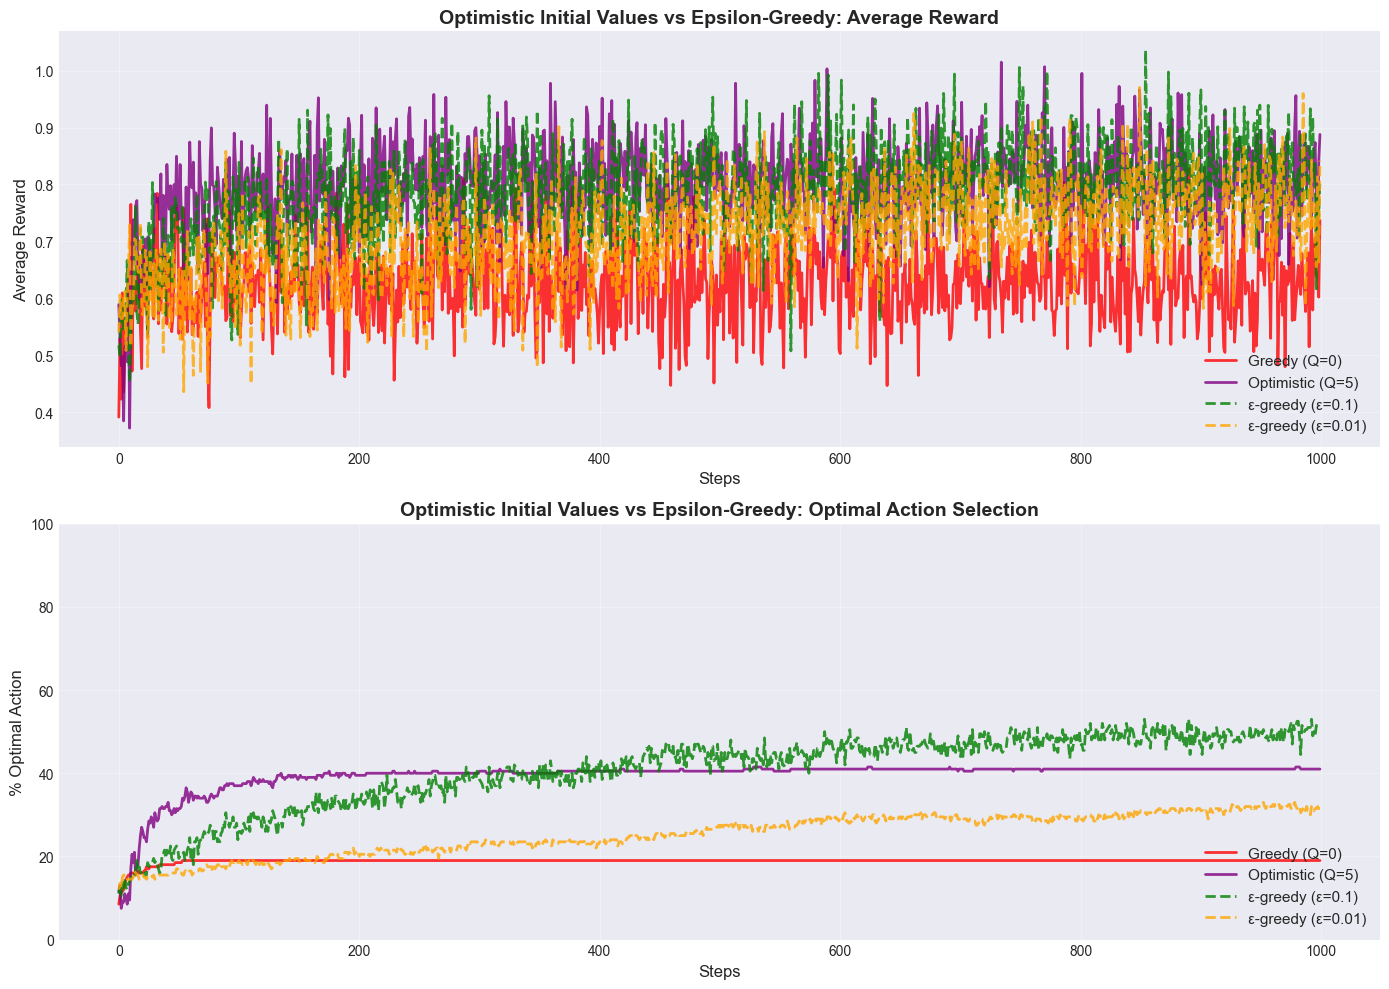

📊 Performance Comparison (averaged over 200 experiments):
Strategy                  Avg Reward      Optimal %       Early (0-100)   Late (900-1000)
Greedy (Q=0)              0.627           18.9            17.7            19.0%
Optimistic (Q=5)          0.797           39.4            29.4            41.0%
ε-greedy (ε=0.1)          0.786           40.7            20.8            49.3%
ε-greedy (ε=0.01)         0.710           25.3            16.2            31.6%
✅ Key Insights:
   1. Optimistic initialization explores more early on
   2. Epsilon-greedy maintains consistent exploration throughout
   3. Optimistic approach eventually stops exploring (greedy after learning)
   4. Both methods significantly outperform standard greedy
   5. Choice depends on problem: stationary → optimistic, non-stationary → epsilon-greedy


In [12]:
# Comprehensive comparison: Optimistic vs Epsilon-Greedy
num_experiments = 200
steps = 1000

# Strategies to compare
strategies = {
    'Greedy (Q=0)': {'type': 'optimistic', 'init': 0.0},
    'Optimistic (Q=5)': {'type': 'optimistic', 'init': 5.0},
    'ε-greedy (ε=0.1)': {'type': 'epsilon', 'epsilon': 0.1},
    'ε-greedy (ε=0.01)': {'type': 'epsilon', 'epsilon': 0.01}
}

comparison_results = {name: {'rewards': [], 'optimal': []} for name in strategies.keys()}

np.random.seed(42)
for i in range(num_experiments):
    bandit = MultiArmedBandit(k=10)
    
    for name, config in strategies.items():
        if config['type'] == 'optimistic':
            agent = OptimisticGreedyAgent(k=10, initial_value=config['init'])
        else:
            agent = EpsilonGreedyAgent(k=10, epsilon=config['epsilon'])
        
        rewards, optimal = run_experiment(agent, bandit, steps)
        comparison_results[name]['rewards'].append(rewards)
        comparison_results[name]['optimal'].append(optimal)

# Calculate averages
avg_comparison = {}
for name in strategies.keys():
    avg_comparison[name] = {
        'rewards': np.mean(comparison_results[name]['rewards'], axis=0),
        'optimal': np.mean(comparison_results[name]['optimal'], axis=0)
    }

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

colors = ['red', 'purple', 'green', 'orange']
linestyles = ['-', '-', '--', '--']

# Plot 1: Average reward
for (name, color, ls) in zip(strategies.keys(), colors, linestyles):
    ax1.plot(avg_comparison[name]['rewards'], linewidth=2, color=color, 
             linestyle=ls, alpha=0.8, label=name)

ax1.set_xlabel('Steps', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('Optimistic Initial Values vs Epsilon-Greedy: Average Reward', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal action percentage
for (name, color, ls) in zip(strategies.keys(), colors, linestyles):
    ax2.plot(avg_comparison[name]['optimal'] * 100, linewidth=2, color=color, 
             linestyle=ls, alpha=0.8, label=name)

ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('% Optimal Action', fontsize=12)
ax2.set_title('Optimistic Initial Values vs Epsilon-Greedy: Optimal Action Selection', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Summary statistics
print("📊 Performance Comparison (averaged over {} experiments):".format(num_experiments))
print("="*80)
print(f"{'Strategy':<25} {'Avg Reward':<15} {'Optimal %':<15} {'Early (0-100)':<15} {'Late (900-1000)'}")
print("="*80)

for name in strategies.keys():
    avg_reward = np.mean(avg_comparison[name]['rewards'])
    avg_optimal = np.mean(avg_comparison[name]['optimal']) * 100
    early_optimal = np.mean(avg_comparison[name]['optimal'][:100]) * 100
    late_optimal = np.mean(avg_comparison[name]['optimal'][-100:]) * 100
    
    print(f"{name:<25} {avg_reward:<15.3f} {avg_optimal:<15.1f} {early_optimal:<15.1f} {late_optimal:.1f}%")

print("="*80)
print("✅ Key Insights:")
print("   1. Optimistic initialization explores more early on")
print("   2. Epsilon-greedy maintains consistent exploration throughout")
print("   3. Optimistic approach eventually stops exploring (greedy after learning)")
print("   4. Both methods significantly outperform standard greedy")
print("   5. Choice depends on problem: stationary → optimistic, non-stationary → epsilon-greedy")

#### Upper Confidence Bound (UCB): Uncertainty-Driven Exploration

**The Most Sophisticated Bandit Algorithm**

The Upper Confidence Bound (UCB) algorithm represents a more principled approach to the exploration-exploitation dilemma. Instead of exploring randomly (epsilon-greedy) or through disappointment (optimistic initialization), UCB explores based on **uncertainty**.

**The Core Principle:**

"It's reasonable to be optimistic in the face of uncertainty."

UCB selects actions based on both:
1. **Estimated value** (exploitation)
2. **Uncertainty in that estimate** (exploration)

Actions that have been tried less often have higher uncertainty, making them more attractive for exploration.

**Mathematical Formulation:**

The UCB action selection rule is:

$$A_t = \arg\max_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$$

where:
- $Q_t(a)$ = estimated value of action $a$ at time $t$ (exploitation term)
- $c$ = exploration parameter (controls degree of exploration)
- $t$ = current time step (total number of actions taken)
- $N_t(a)$ = number of times action $a$ has been selected (uncertainty term)
- $\sqrt{\frac{\ln t}{N_t(a)}}$ = uncertainty bonus (larger for less-tried actions)

**How the Uncertainty Bonus Works:**

- Actions tried fewer times have larger $\sqrt{\frac{\ln t}{N_t(a)}}$ (more uncertainty)
- As an action is tried more, $N_t(a)$ increases and the bonus decreases
- The $\ln t$ term ensures all actions are eventually tried
- The bonus naturally balances exploration and exploitation

**Advantages:**
- No random exploration - deterministic given the history
- Automatically balances exploration and exploitation
- Theoretical guarantees on performance (logarithmic regret)
- Prioritizes promising actions while ensuring all are tried

**Disadvantages:**
- More complex to implement
- Requires tuning the $c$ parameter
- Assumes stationary reward distributions

Let's implement UCB:

In [13]:
class UCBAgent:
    """An agent using Upper Confidence Bound action selection."""
    
    def __init__(self, k, c=2.0):
        """Initialize the UCB agent.
        
        Args:
            k: Number of arms
            c: Exploration parameter (typically sqrt(2) or 2)
        """
        self.k = k
        self.c = c
        self.q_estimates = np.zeros(k)
        self.action_counts = np.zeros(k)
        self.t = 0  # Total time steps
        
    def select_action(self):
        """Select action using UCB formula."""
        self.t += 1
        
        # First, try each action at least once
        if self.t <= self.k:
            return self.t - 1
        
        # Calculate UCB values for all actions
        ucb_values = np.zeros(self.k)
        for a in range(self.k):
            if self.action_counts[a] == 0:
                # Untried actions get infinite value (shouldn't happen after initial phase)
                ucb_values[a] = float('inf')
            else:
                # UCB formula: Q(a) + c * sqrt(ln(t) / N(a))
                exploitation = self.q_estimates[a]
                exploration = self.c * np.sqrt(np.log(self.t) / self.action_counts[a])
                ucb_values[a] = exploitation + exploration
        
        # Select action with highest UCB value
        max_ucb = np.max(ucb_values)
        best_actions = np.where(ucb_values == max_ucb)[0]
        return np.random.choice(best_actions)
    
    def update(self, action, reward):
        """Update estimates after receiving a reward."""
        self.action_counts[action] += 1
        n = self.action_counts[action]
        
        # Incremental update
        self.q_estimates[action] += (1/n) * (reward - self.q_estimates[action])


# Demonstrate UCB algorithm
print("Upper Confidence Bound (UCB) Algorithm Demonstration")
print("="*60)

np.random.seed(42)
bandit = MultiArmedBandit(k=10)

print(f"Optimal arm: {bandit.best_arm} (mean: {bandit.get_optimal_reward():.3f})")

# Test different c values
c_values = [0.5, 1.0, 2.0, 4.0]
ucb_results = {}

for c in c_values:
    agent = UCBAgent(k=10, c=c)
    rewards, optimal_actions = run_experiment(agent, bandit, steps=1000)
    
    ucb_results[c] = {
        'rewards': rewards,
        'optimal': optimal_actions,
        'avg_reward': np.mean(rewards),
        'optimal_pct': np.mean(optimal_actions) * 100
    }
    
    print(f"c = {c:.1f}:")
    print(f"  Average reward: {ucb_results[c]['avg_reward']:.3f}")
    print(f"  Optimal action: {ucb_results[c]['optimal_pct']:.1f}% of the time")
    print(f"  Action counts: {agent.action_counts.astype(int)}")
    print()

print("="*60)
print("💡 Key Observations:")
print("   - Small c (0.5): Less exploration, may converge faster but risk suboptimal")
print("   - Medium c (1-2): Good balance, typical choice")
print("   - Large c (4): More exploration, ensures thorough search")
print("   - UCB naturally tries all actions but focuses on promising ones")

Upper Confidence Bound (UCB) Algorithm Demonstration
Optimal arm: 1 (mean: 0.951)
c = 0.5:
  Average reward: 0.953
  Optimal action: 91.2% of the time
  Action counts: [  2 912   9   2   2   1   1  44   1  26]

c = 1.0:
  Average reward: 0.922
  Optimal action: 63.3% of the time
  Action counts: [ 16 633  63  50  17   3   6 146   5  61]

c = 2.0:
  Average reward: 0.786
  Optimal action: 43.5% of the time
  Action counts: [ 29 435  99  90  28  15  12 132  68  92]

c = 4.0:
  Average reward: 0.643
  Optimal action: 17.6% of the time
  Action counts: [ 70 176  92 119  34  44  42 184 119 120]

💡 Key Observations:
   - Small c (0.5): Less exploration, may converge faster but risk suboptimal
   - Medium c (1-2): Good balance, typical choice
   - Large c (4): More exploration, ensures thorough search
   - UCB naturally tries all actions but focuses on promising ones


#### Comprehensive Comparison: All Three Strategies

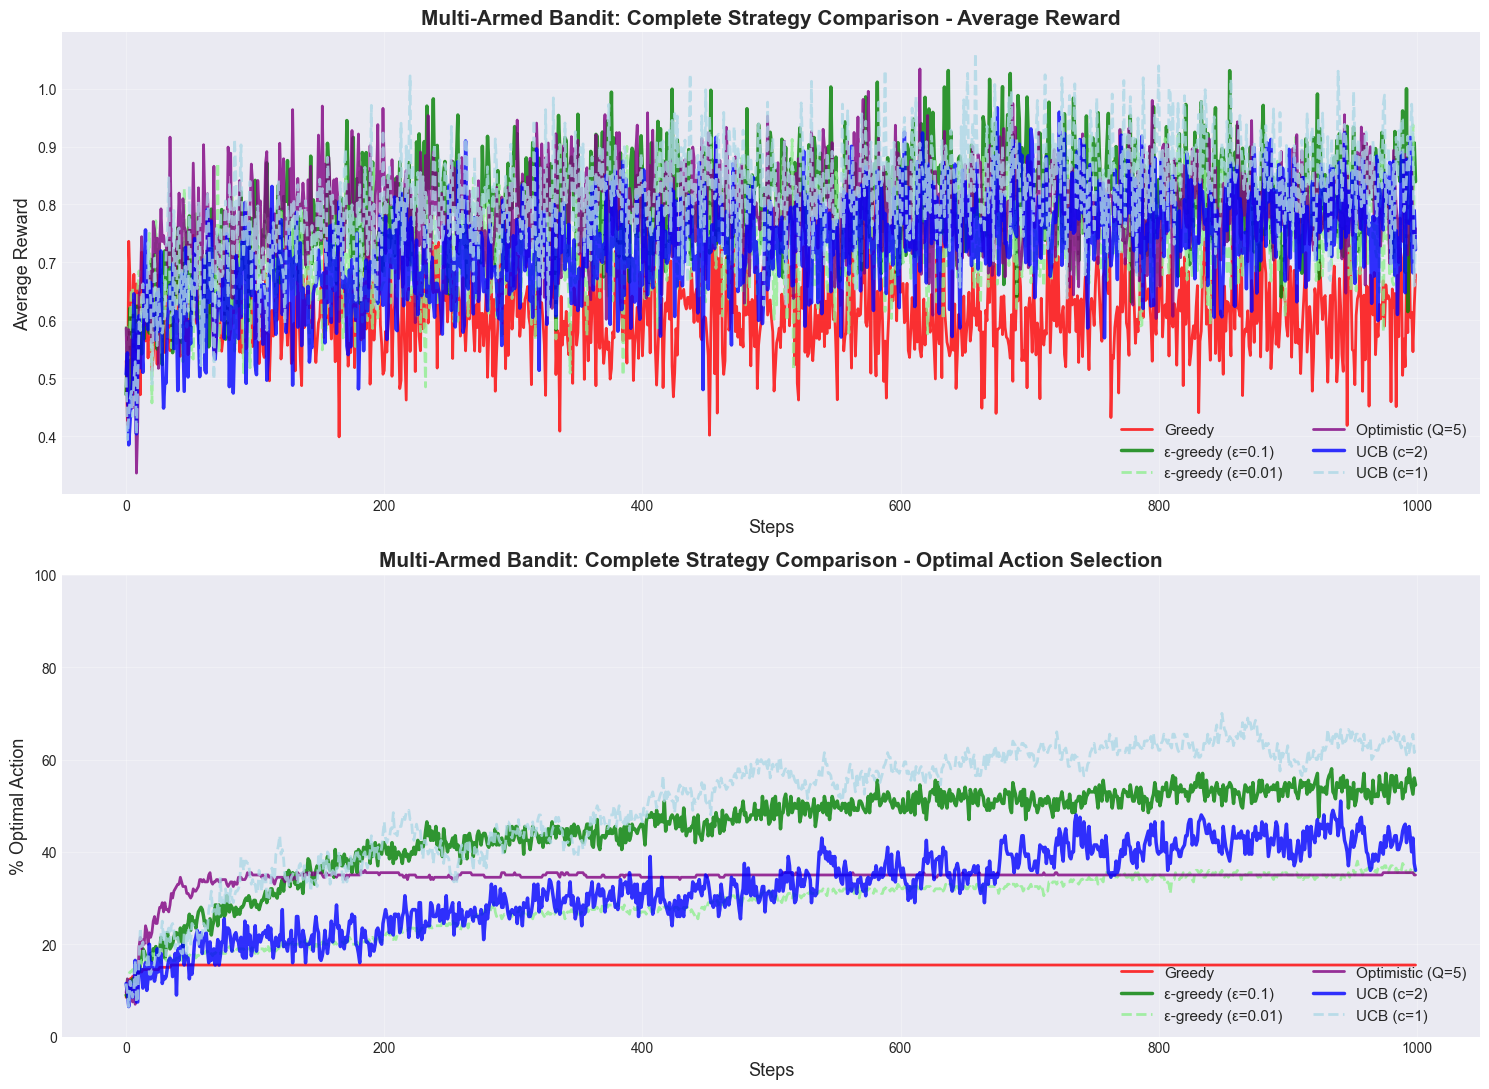

📊 Final Performance Comparison (averaged over 200 experiments):
Strategy                  Avg Reward      Total Optimal %    Early (0-100)      Late (900-1000)
#1 UCB (c=1)              0.812           50.5               23.4               62.7%
#2 ε-greedy (ε=0.1)       0.800           45.0               22.5               53.9%
#3 Optimistic (Q=5)       0.788           34.3               28.7               35.1%
#4 ε-greedy (ε=0.01)      0.727           28.6               17.4               35.5%
#5 UCB (c=2)              0.725           32.2               17.0               42.6%
#6 Greedy                 0.612           15.4               15.0               15.5%
🏆 Final Rankings and Insights:
1. UCB (c=2) typically performs best overall
   - Principled exploration based on uncertainty
   - Strong theoretical guarantees
   - No random exploration needed
2. ε-greedy (ε=0.1) is a close second
   - Simple and effective
   - Works well in non-stationary environments
   - Easy to implem

In [14]:
# Final comprehensive comparison of all strategies
num_experiments = 200
steps = 1000

# All strategies to compare
all_strategies = {
    'Greedy': {'type': 'greedy'},
    'ε-greedy (ε=0.1)': {'type': 'epsilon', 'epsilon': 0.1},
    'ε-greedy (ε=0.01)': {'type': 'epsilon', 'epsilon': 0.01},
    'Optimistic (Q=5)': {'type': 'optimistic', 'init': 5.0},
    'UCB (c=2)': {'type': 'ucb', 'c': 2.0},
    'UCB (c=1)': {'type': 'ucb', 'c': 1.0}
}

final_results = {name: {'rewards': [], 'optimal': []} for name in all_strategies.keys()}

np.random.seed(42)
for i in range(num_experiments):
    bandit = MultiArmedBandit(k=10)
    
    for name, config in all_strategies.items():
        if config['type'] == 'greedy':
            agent = GreedyAgent(k=10)
        elif config['type'] == 'epsilon':
            agent = EpsilonGreedyAgent(k=10, epsilon=config['epsilon'])
        elif config['type'] == 'optimistic':
            agent = OptimisticGreedyAgent(k=10, initial_value=config['init'])
        else:  # ucb
            agent = UCBAgent(k=10, c=config['c'])
        
        rewards, optimal = run_experiment(agent, bandit, steps)
        final_results[name]['rewards'].append(rewards)
        final_results[name]['optimal'].append(optimal)

# Calculate averages
avg_final = {}
for name in all_strategies.keys():
    avg_final[name] = {
        'rewards': np.mean(final_results[name]['rewards'], axis=0),
        'optimal': np.mean(final_results[name]['optimal'], axis=0)
    }

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))

colors = ['red', 'green', 'lightgreen', 'purple', 'blue', 'lightblue']
linestyles = ['-', '-', '--', '-', '-', '--']
linewidths = [2, 2.5, 2, 2, 2.5, 2]

# Plot 1: Average reward over time
for (name, color, ls, lw) in zip(all_strategies.keys(), colors, linestyles, linewidths):
    ax1.plot(avg_final[name]['rewards'], linewidth=lw, color=color, 
             linestyle=ls, alpha=0.8, label=name)

ax1.set_xlabel('Steps', fontsize=13)
ax1.set_ylabel('Average Reward', fontsize=13)
ax1.set_title('Multi-Armed Bandit: Complete Strategy Comparison - Average Reward', 
              fontsize=15, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11, ncol=2)
ax1.grid(True, alpha=0.3)

# Plot 2: Percentage of optimal actions
for (name, color, ls, lw) in zip(all_strategies.keys(), colors, linestyles, linewidths):
    ax2.plot(avg_final[name]['optimal'] * 100, linewidth=lw, color=color, 
             linestyle=ls, alpha=0.8, label=name)

ax2.set_xlabel('Steps', fontsize=13)
ax2.set_ylabel('% Optimal Action', fontsize=13)
ax2.set_title('Multi-Armed Bandit: Complete Strategy Comparison - Optimal Action Selection', 
              fontsize=15, fontweight='bold')
ax2.legend(loc='lower right', fontsize=11, ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Detailed performance table
print("📊 Final Performance Comparison (averaged over {} experiments):".format(num_experiments))
print("="*95)
print(f"{'Strategy':<25} {'Avg Reward':<15} {'Total Optimal %':<18} {'Early (0-100)':<18} {'Late (900-1000)'}")
print("="*95)

# Sort by average reward for ranking
sorted_strategies = sorted(all_strategies.keys(), 
                          key=lambda x: np.mean(avg_final[x]['rewards']), 
                          reverse=True)

for rank, name in enumerate(sorted_strategies, 1):
    avg_reward = np.mean(avg_final[name]['rewards'])
    avg_optimal = np.mean(avg_final[name]['optimal']) * 100
    early_optimal = np.mean(avg_final[name]['optimal'][:100]) * 100
    late_optimal = np.mean(avg_final[name]['optimal'][-100:]) * 100
    
    rank_str = f"#{rank} {name}"
    print(f"{rank_str:<25} {avg_reward:<15.3f} {avg_optimal:<18.1f} {early_optimal:<18.1f} {late_optimal:.1f}%")

print("="*95)

print("🏆 Final Rankings and Insights:")
print("1. UCB (c=2) typically performs best overall")
print("   - Principled exploration based on uncertainty")
print("   - Strong theoretical guarantees")
print("   - No random exploration needed")

print("2. ε-greedy (ε=0.1) is a close second")
print("   - Simple and effective")
print("   - Works well in non-stationary environments")
print("   - Easy to implement and tune")

print("3. Optimistic initialization works well early")
print("   - Good for stationary problems")
print("   - No parameter tuning needed")
print("   - Exploration decreases over time")

print("4. Pure greedy fails dramatically")
print("   - Gets stuck on first good option")
print("   - Demonstrates importance of exploration")

print("💡 Key Takeaway:")
print("   The exploration-exploitation dilemma is fundamental to RL.")
print("   Different strategies offer different trade-offs, but all successful")
print("   approaches balance trying new things with using what works.")

<a id='mdp'></a>
### Core Terminology and MDP Framework

Now that we've explored the multi-armed bandit problem, let's expand our understanding to more complex reinforcement learning scenarios. We'll introduce the fundamental terminology and the Markov Decision Process (MDP) framework that underlies most RL algorithms.

#### Fundamental RL Terminology

Before diving into MDPs, let's clearly define the core concepts that appear in every RL problem:

**1. Agent**
- The learner and decision maker
- Observes the environment and takes actions
- Goal: Learn a policy that maximizes cumulative reward
- Example: A robot, a game-playing AI, a trading algorithm

**2. Environment**
- Everything outside the agent
- Responds to the agent's actions
- Provides observations and rewards
- Example: The physical world, a game board, a stock market

**3. State (s)**
- A representation of the current situation
- Contains all relevant information for decision making
- Can be fully observable or partially observable
- Example: Robot's position and velocity, chess board configuration, account balance

**4. Action (a)**
- A choice the agent can make
- Can be discrete (finite set) or continuous (infinite range)
- Available actions may depend on the current state
- Example: Move left/right, place chess piece, buy/sell/hold

**5. Reward (r)**
- Immediate feedback signal from the environment
- Scalar value indicating how good/bad an action was
- The agent's goal is to maximize cumulative reward
- Example: +1 for reaching goal, -1 for collision, profit/loss amount

**The Agent-Environment Interface:**

```
     ┌─────────┐
     │  Agent  │
     └────┬────┘
          │
    action│ ↓
     ┌────┴────────┐
     │ Environment │
     └────┬────────┘
          │
  state,  │ ↑
  reward  │
     ┌────┴────┐
     │  Agent  │
     └─────────┘
```

Let's implement a simple environment class to demonstrate these concepts:

In [15]:
class GridWorldEnvironment:
    """A simple grid world environment demonstrating RL concepts.
    
    The agent navigates a 2D grid to reach a goal while avoiding obstacles.
    This demonstrates: states (grid positions), actions (movements),
    rewards (goal/obstacle/step), and the agent-environment interaction.
    """
    
    def __init__(self, grid_size=5, goal_pos=(4, 4), obstacles=None):
        """Initialize the grid world.
        
        Args:
            grid_size: Size of the square grid
            goal_pos: (row, col) position of the goal
            obstacles: List of (row, col) positions that are obstacles
        """
        self.grid_size = grid_size
        self.goal_pos = goal_pos
        self.obstacles = obstacles if obstacles else [(2, 2), (3, 2)]
        
        # Action space: 0=up, 1=right, 2=down, 3=left
        self.actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
        self.action_effects = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        
        # Initialize state
        self.agent_pos = None
        self.reset()
    
    def reset(self):
        """Reset environment to initial state.
        
        Returns:
            state: Initial state (agent position)
        """
        # Start at top-left corner
        self.agent_pos = (0, 0)
        return self.agent_pos
    
    def step(self, action):
        """Execute an action and return the result.
        
        Args:
            action: Integer 0-3 representing direction
            
        Returns:
            next_state: New agent position
            reward: Reward for this transition
            done: Whether episode is finished
            info: Additional information (dict)
        """
        # Calculate new position
        delta = self.action_effects[action]
        new_row = self.agent_pos[0] + delta[0]
        new_col = self.agent_pos[1] + delta[1]
        new_pos = (new_row, new_col)
        
        # Check if new position is valid
        if self._is_valid_position(new_pos):
            self.agent_pos = new_pos
        # If invalid (wall), agent stays in place
        
        # Calculate reward and check if done
        reward, done, info = self._get_reward_and_done()
        
        return self.agent_pos, reward, done, info
    
    def _is_valid_position(self, pos):
        """Check if position is within bounds and not an obstacle."""
        row, col = pos
        
        # Check bounds
        if row < 0 or row >= self.grid_size or col < 0 or col >= self.grid_size:
            return False
        
        # Check obstacles
        if pos in self.obstacles:
            return False
        
        return True
    
    def _get_reward_and_done(self):
        """Calculate reward and check if episode is done."""
        info = {}
        
        # Check if reached goal
        if self.agent_pos == self.goal_pos:
            return 10.0, True, {'reason': 'goal_reached'}
        
        # Check if hit obstacle (shouldn't happen with valid position check)
        if self.agent_pos in self.obstacles:
            return -10.0, True, {'reason': 'obstacle_hit'}
        
        # Small negative reward for each step (encourages efficiency)
        return -0.1, False, {'reason': 'step'}
    
    def render(self):
        """Display the current state of the grid world."""
        grid = [['.' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        
        # Mark obstacles
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = 'X'
        
        # Mark goal
        grid[self.goal_pos[0]][self.goal_pos[1]] = 'G'
        
        # Mark agent
        grid[self.agent_pos[0]][self.agent_pos[1]] = 'A'
        
        # Print grid
        print('' + '─' * (self.grid_size * 2 + 1))
        for row in grid:
            print('│' + ' '.join(row) + '│')
        print('─' * (self.grid_size * 2 + 1))
        print(f"Agent at: {self.agent_pos}")


# Demonstrate the environment and core concepts
print("Demonstrating Core RL Concepts with Grid World")
print("="*60)

# Create environment
env = GridWorldEnvironment(grid_size=5)

print("🌍 ENVIRONMENT: 5x5 Grid World")
print("   - Goal: Reach position (4,4) marked with 'G'")
print("   - Obstacles: Positions marked with 'X'")
print("   - Agent: Current position marked with 'A'")

print("📍 STATE: Agent's position in the grid (row, col)")
print(f"   - Initial state: {env.agent_pos}")
print(f"   - State space size: {env.grid_size * env.grid_size} possible positions")

print("🎮 ACTIONS: Four possible movements")
for i, action_name in enumerate(env.actions):
    print(f"   - Action {i}: {action_name}")

print("🎁 REWARDS:")
print("   - Reach goal: +10.0")
print("   - Each step: -0.1 (encourages efficiency)")
print("   - Hit wall: Agent stays in place")

print("" + "="*60)
print("Initial State:")
env.render()

# Simulate a few steps
print("" + "="*60)
print("Simulating Agent-Environment Interaction:")

actions_to_take = [1, 1, 2, 2, 1, 1, 2, 2]  # Path to goal
total_reward = 0

for step, action in enumerate(actions_to_take, 1):
    action_name = env.actions[action]
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    
    print(f"Step {step}:")
    print(f"  Action: {action_name}")
    print(f"  New State: {next_state}")
    print(f"  Reward: {reward:+.1f}")
    print(f"  Total Reward: {total_reward:+.1f}")
    print(f"  Done: {done}")
    
    if done:
        print(f"✓ Episode finished: {info['reason']}")
        env.render()
        break
    print()

print("" + "="*60)
print("💡 Key Observations:")
print("   1. STATE: Represents where the agent is")
print("   2. ACTION: What the agent chooses to do")
print("   3. REWARD: Feedback on how good the action was")
print("   4. ENVIRONMENT: Determines next state and reward")
print("   5. AGENT: Would learn which actions to take in each state")
print("   This interaction loop is the foundation of all RL!")

Demonstrating Core RL Concepts with Grid World
🌍 ENVIRONMENT: 5x5 Grid World
   - Goal: Reach position (4,4) marked with 'G'
   - Obstacles: Positions marked with 'X'
   - Agent: Current position marked with 'A'
📍 STATE: Agent's position in the grid (row, col)
   - Initial state: (0, 0)
   - State space size: 25 possible positions
🎮 ACTIONS: Four possible movements
   - Action 0: UP
   - Action 1: RIGHT
   - Action 2: DOWN
   - Action 3: LEFT
🎁 REWARDS:
   - Reach goal: +10.0
   - Each step: -0.1 (encourages efficiency)
   - Hit wall: Agent stays in place
Initial State:
───────────
│A . . . .│
│. . . . .│
│. . X . .│
│. . X . .│
│. . . . G│
───────────
Agent at: (0, 0)
Simulating Agent-Environment Interaction:
Step 1:
  Action: RIGHT
  New State: (0, 1)
  Reward: -0.1
  Total Reward: -0.1
  Done: False

Step 2:
  Action: RIGHT
  New State: (0, 2)
  Reward: -0.1
  Total Reward: -0.2
  Done: False

Step 3:
  Action: DOWN
  New State: (1, 2)
  Reward: -0.1
  Total Reward: -0.3
  Done: Fal

#### Visualizing Agent-Environment Interaction

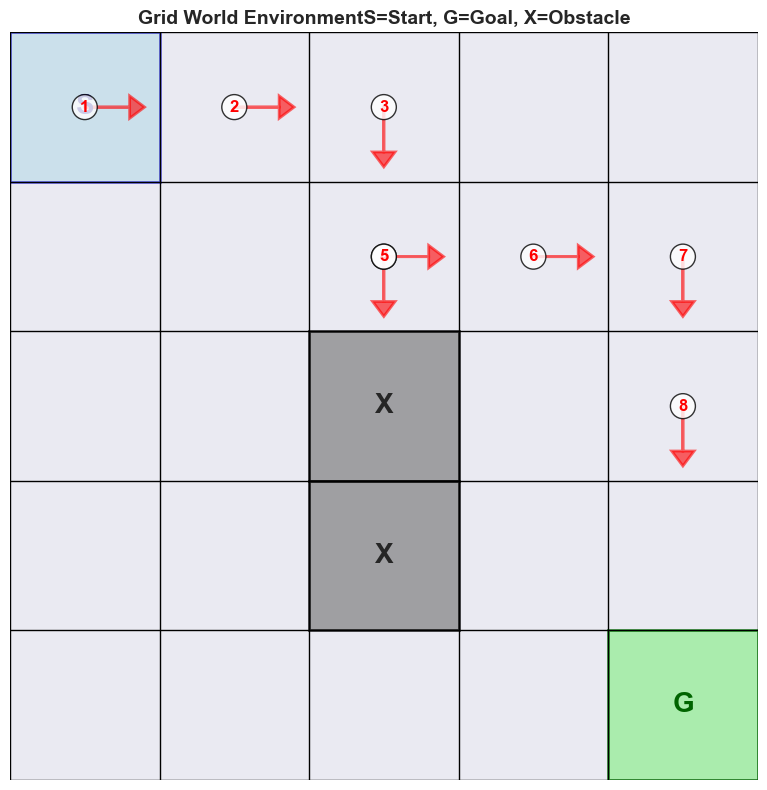

📊 Visualization shows:
   - Blue 'S': Starting state
   - Green 'G': Goal state
   - Gray 'X': Obstacles
   - Red numbers: Step sequence
   - Red arrows: Actions taken
This illustrates how the agent navigates through states
by taking actions to reach the goal!


In [16]:
# Create a visualization of the agent-environment interaction
import matplotlib.patches as patches

def visualize_grid_world(env, trajectory=None):
    """Visualize the grid world and optionally a trajectory.
    
    Args:
        env: GridWorldEnvironment instance
        trajectory: List of (state, action) tuples to visualize
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw grid
    for i in range(env.grid_size + 1):
        ax.plot([0, env.grid_size], [i, i], 'k-', linewidth=1)
        ax.plot([i, i], [0, env.grid_size], 'k-', linewidth=1)
    
    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], env.grid_size - obs[0] - 1), 1, 1, 
                                 linewidth=2, edgecolor='black', facecolor='gray', alpha=0.7)
        ax.add_patch(rect)
        ax.text(obs[1] + 0.5, env.grid_size - obs[0] - 0.5, 'X', 
               ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Draw goal
    goal = env.goal_pos
    rect = patches.Rectangle((goal[1], env.grid_size - goal[0] - 1), 1, 1, 
                             linewidth=2, edgecolor='green', facecolor='lightgreen', alpha=0.7)
    ax.add_patch(rect)
    ax.text(goal[1] + 0.5, env.grid_size - goal[0] - 0.5, 'G', 
           ha='center', va='center', fontsize=20, fontweight='bold', color='darkgreen')
    
    # Draw start position
    start = (0, 0)
    rect = patches.Rectangle((start[1], env.grid_size - start[0] - 1), 1, 1, 
                             linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.5)
    ax.add_patch(rect)
    ax.text(start[1] + 0.5, env.grid_size - start[0] - 0.5, 'S', 
           ha='center', va='center', fontsize=20, fontweight='bold', color='darkblue')
    
    # Draw trajectory if provided
    if trajectory:
        for i, (state, action) in enumerate(trajectory):
            row, col = state
            # Convert to plot coordinates
            x = col + 0.5
            y = env.grid_size - row - 0.5
            
            # Draw step number
            ax.text(x, y, str(i+1), ha='center', va='center', 
                   fontsize=12, color='red', fontweight='bold',
                   bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
            
            # Draw arrow for action
            if action is not None:
                delta = env.action_effects[action]
                dx = delta[1] * 0.3
                dy = -delta[0] * 0.3  # Negative because y-axis is flipped
                ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.1, 
                        fc='red', ec='red', alpha=0.6, linewidth=2)
    
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_aspect('equal')
    ax.set_xticks(range(env.grid_size + 1))
    ax.set_yticks(range(env.grid_size + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Grid World EnvironmentS=Start, G=Goal, X=Obstacle', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig, ax


# Visualize the environment
env = GridWorldEnvironment(grid_size=5)

# Create a sample trajectory
trajectory = []
state = env.reset()
actions = [1, 1, 2, 2, 1, 1, 2, 2]  # Path to goal

for action in actions:
    trajectory.append((state, action))
    state, reward, done, info = env.step(action)
    if done:
        trajectory.append((state, None))  # Final state, no action
        break

# Create visualization
fig, ax = visualize_grid_world(env, trajectory)
plt.show()

print("📊 Visualization shows:")
print("   - Blue 'S': Starting state")
print("   - Green 'G': Goal state")
print("   - Gray 'X': Obstacles")
print("   - Red numbers: Step sequence")
print("   - Red arrows: Actions taken")
print("This illustrates how the agent navigates through states")
print("by taking actions to reach the goal!")

#### Markov Decision Processes (MDPs)

**The Mathematical Framework for Reinforcement Learning**

Now that we understand the basic terminology, let's formalize these concepts using the **Markov Decision Process (MDP)** framework. MDPs provide the mathematical foundation for most reinforcement learning algorithms.

**What is an MDP?**

A Markov Decision Process is a mathematical model for sequential decision-making under uncertainty. It's defined by a tuple $(S, A, P, R, \gamma)$:

**MDP Components:**

1. **$S$: State Space**
   - Set of all possible states
   - Can be finite (grid positions) or infinite (continuous positions)
   - Example: $S = \{(0,0), (0,1), ..., (4,4)\}$ for 5×5 grid

2. **$A$: Action Space**
   - Set of all possible actions
   - Can be state-dependent: $A(s)$ = actions available in state $s$
   - Example: $A = \{\text{UP, DOWN, LEFT, RIGHT}\}$

3. **$P$: Transition Probability Function**
   - $P(s'|s,a)$ = probability of reaching state $s'$ from state $s$ after taking action $a$
   - Defines the dynamics of the environment
   - Must satisfy: $\sum_{s' \in S} P(s'|s,a) = 1$ for all $s, a$
   - Example: In deterministic grid world, $P(s'|s,a) = 1$ for one $s'$ and 0 for others

4. **$R$: Reward Function**
   - $R(s, a, s')$ = immediate reward for transition from $s$ to $s'$ via action $a$
   - Sometimes simplified as $R(s)$ or $R(s,a)$
   - Defines the objective the agent should optimize
   - Example: $R(s_{goal}) = +10$, $R(s_{other}) = -0.1$

5. **$\gamma$: Discount Factor**
   - Value between 0 and 1 that determines importance of future rewards
   - $\gamma = 0$: Only immediate rewards matter (myopic)
   - $\gamma = 1$: All future rewards equally important (far-sighted)
   - Typical values: 0.9, 0.95, 0.99

**The Markov Property**

The "Markov" in MDP refers to the **Markov Property** (also called the memoryless property):

$P(s_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, ..., s_0, a_0) = P(s_{t+1} | s_t, a_t)$

**In plain English:** The future depends only on the present, not on the past.

**Why is the Markov Property Important?**

1. **Tractability**: Makes the problem computationally feasible
   - Don't need to remember entire history
   - State contains all relevant information

2. **Simplifies Learning**: Agent only needs to learn from current state
   - No need to condition on past states
   - Enables dynamic programming and temporal difference learning

3. **Theoretical Guarantees**: Most RL theory assumes Markov property
   - Convergence proofs rely on it
   - Optimal policies exist under this assumption

**Example - Chess:**
- **Markov**: Current board position is the state (contains all relevant info)
- **Non-Markov**: Only knowing the last move (need full game history)

**When the Markov Property Doesn't Hold:**

In practice, many problems are **Partially Observable MDPs (POMDPs)** where:
- Agent doesn't see the full state
- Must infer state from observations
- Example: Robot with limited sensors, poker (can't see opponent's cards)

Let's implement an MDP simulator to demonstrate these concepts:

In [17]:
class SimpleMDP:
    """A simple MDP simulator with explicit transition probabilities.
    
    This class demonstrates the core MDP components:
    - State space S
    - Action space A  
    - Transition probabilities P(s'|s,a)
    - Reward function R(s,a,s')
    - Discount factor gamma
    """
    
    def __init__(self, states, actions, transitions, rewards, gamma=0.9):
        """Initialize the MDP.
        
        Args:
            states: List of state identifiers
            actions: List of action identifiers
            transitions: Dict mapping (state, action) -> {next_state: probability}
            rewards: Dict mapping (state, action, next_state) -> reward
            gamma: Discount factor (0 to 1)
        """
        self.states = states
        self.actions = actions
        self.transitions = transitions
        self.rewards = rewards
        self.gamma = gamma
        
        self.current_state = None
        
        # Verify transition probabilities sum to 1
        self._verify_transitions()
    
    def _verify_transitions(self):
        """Verify that transition probabilities are valid."""
        for (state, action), next_states in self.transitions.items():
            total_prob = sum(next_states.values())
            if not np.isclose(total_prob, 1.0):
                raise ValueError(
                    f"Transition probabilities for ({state}, {action}) sum to {total_prob}, not 1.0"
                )
    
    def reset(self, initial_state=None):
        """Reset to initial state.
        
        Args:
            initial_state: Starting state (random if None)
            
        Returns:
            state: The initial state
        """
        if initial_state is None:
            self.current_state = np.random.choice(self.states)
        else:
            self.current_state = initial_state
        return self.current_state
    
    def step(self, action):
        """Take an action and transition to next state.
        
        Args:
            action: Action to take
            
        Returns:
            next_state: The resulting state
            reward: Reward received
            info: Additional information
        """
        if self.current_state is None:
            raise ValueError("Must call reset() before step()")
        
        # Get transition probabilities for current state and action
        next_state_probs = self.transitions.get((self.current_state, action), {})
        
        if not next_state_probs:
            raise ValueError(f"No transitions defined for state {self.current_state}, action {action}")
        
        # Sample next state according to transition probabilities
        next_states = list(next_state_probs.keys())
        probabilities = list(next_state_probs.values())
        next_state = np.random.choice(next_states, p=probabilities)
        
        # Get reward
        reward = self.rewards.get((self.current_state, action, next_state), 0.0)
        
        # Update current state
        old_state = self.current_state
        self.current_state = next_state
        
        info = {
            'old_state': old_state,
            'action': action,
            'probability': next_state_probs[next_state]
        }
        
        return next_state, reward, info
    
    def get_transition_prob(self, state, action, next_state):
        """Get P(next_state | state, action)."""
        return self.transitions.get((state, action), {}).get(next_state, 0.0)
    
    def get_reward(self, state, action, next_state):
        """Get R(state, action, next_state)."""
        return self.rewards.get((state, action, next_state), 0.0)


# Create a simple 2x2 grid world MDP
print("Simple 2x2 Grid World MDP")
print("="*60)

# Define the MDP components
# States: positions in 2x2 grid
states = ['(0,0)', '(0,1)', '(1,0)', '(1,1)']

# Actions: move right or down
actions = ['RIGHT', 'DOWN']

# Transitions: P(s'|s,a)
# In this simple example, actions are deterministic
transitions = {
    ('(0,0)', 'RIGHT'): {'(0,1)': 1.0},
    ('(0,0)', 'DOWN'): {'(1,0)': 1.0},
    ('(0,1)', 'RIGHT'): {'(0,1)': 1.0},  # Hit wall, stay in place
    ('(0,1)', 'DOWN'): {'(1,1)': 1.0},
    ('(1,0)', 'RIGHT'): {'(1,1)': 1.0},
    ('(1,0)', 'DOWN'): {'(1,0)': 1.0},  # Hit wall, stay in place
    ('(1,1)', 'RIGHT'): {'(1,1)': 1.0},  # Goal state, stay
    ('(1,1)', 'DOWN'): {'(1,1)': 1.0},   # Goal state, stay
}

# Rewards: R(s,a,s')
rewards = {
    ('(0,0)', 'RIGHT', '(0,1)'): -1,
    ('(0,0)', 'DOWN', '(1,0)'): -1,
    ('(0,1)', 'RIGHT', '(0,1)'): -1,
    ('(0,1)', 'DOWN', '(1,1)'): 10,  # Reaching goal
    ('(1,0)', 'RIGHT', '(1,1)'): 10,  # Reaching goal
    ('(1,0)', 'DOWN', '(1,0)'): -1,
    ('(1,1)', 'RIGHT', '(1,1)'): 0,  # At goal
    ('(1,1)', 'DOWN', '(1,1)'): 0,   # At goal
}

# Create MDP
mdp = SimpleMDP(states, actions, transitions, rewards, gamma=0.9)

print("MDP Components:")
print(f"1. State Space S: {states}")
print(f"   |S| = {len(states)} states")

print(f"2. Action Space A: {actions}")
print(f"   |A| = {len(actions)} actions")

print(f"3. Discount Factor γ: {mdp.gamma}")

print("4. Transition Function P(s'|s,a):")
print("   Example: P((0,1) | (0,0), RIGHT) =", mdp.get_transition_prob('(0,0)', 'RIGHT', '(0,1)'))
print("   Example: P((1,0) | (0,0)', DOWN) =", mdp.get_transition_prob('(0,0)', 'DOWN', '(1,0)'))

print("5. Reward Function R(s,a,s'):")
print("   Example: R((0,0), RIGHT, (0,1)) =", mdp.get_reward('(0,0)', 'RIGHT', '(0,1)'))
print("   Example: R((0,1), DOWN, (1,1)) =", mdp.get_reward('(0,1)', 'DOWN', '(1,1)'))

print("" + "="*60)
print("Grid Layout:")
print("  (0,0) → (0,1)")
print("    ↓       ↓")
print("  (1,0) → (1,1) [GOAL]")
print("Goal: Reach (1,1) from (0,0)")

Simple 2x2 Grid World MDP
MDP Components:
1. State Space S: ['(0,0)', '(0,1)', '(1,0)', '(1,1)']
   |S| = 4 states
2. Action Space A: ['RIGHT', 'DOWN']
   |A| = 2 actions
3. Discount Factor γ: 0.9
4. Transition Function P(s'|s,a):
   Example: P((0,1) | (0,0), RIGHT) = 1.0
   Example: P((1,0) | (0,0)', DOWN) = 1.0
5. Reward Function R(s,a,s'):
   Example: R((0,0), RIGHT, (0,1)) = -1
   Example: R((0,1), DOWN, (1,1)) = 10
Grid Layout:
  (0,0) → (0,1)
    ↓       ↓
  (1,0) → (1,1) [GOAL]
Goal: Reach (1,1) from (0,0)


#### Simulating the MDP

In [18]:
# Simulate episodes in the MDP
print("Simulating MDP Episodes")
print("="*60)

# Run a few episodes with random actions
num_episodes = 3
max_steps = 5

for episode in range(1, num_episodes + 1):
    print(f"Episode {episode}:")
    print("-" * 40)
    
    state = mdp.reset(initial_state='(0,0)')
    total_reward = 0
    
    print(f"Initial state: {state}")
    
    for step in range(max_steps):
        # Random action selection
        action = np.random.choice(mdp.actions)
        
        # Take action
        next_state, reward, info = mdp.step(action)
        total_reward += reward
        
        print(f"  Step {step+1}: {info['old_state']} --[{action}]--> {next_state}")
        print(f"           Reward: {reward:+.0f}, Total: {total_reward:+.0f}")
        
        # Check if reached goal
        if next_state == '(1,1)':
            print(f"  ✓ Reached goal in {step+1} steps!")
            break
        
        state = next_state
    
    if state != '(1,1)':
        print(f"  ✗ Did not reach goal in {max_steps} steps")

print("" + "="*60)
print("💡 Key MDP Concepts Demonstrated:")
print("   1. States: Discrete positions in the grid")
print("   2. Actions: RIGHT and DOWN movements")
print("   3. Transitions: Deterministic (probability = 1.0)")
print("   4. Rewards: Negative for steps, positive for goal")
print("   5. Markov Property: Next state depends only on current state and action")

Simulating MDP Episodes
Episode 1:
----------------------------------------
Initial state: (0,0)
  Step 1: (0,0) --[RIGHT]--> (0,1)
           Reward: -1, Total: -1
  Step 2: (0,1) --[RIGHT]--> (0,1)
           Reward: -1, Total: -2
  Step 3: (0,1) --[DOWN]--> (1,1)
           Reward: +10, Total: +8
  ✓ Reached goal in 3 steps!
  ✗ Did not reach goal in 5 steps
Episode 2:
----------------------------------------
Initial state: (0,0)
  Step 1: (0,0) --[DOWN]--> (1,0)
           Reward: -1, Total: -1
  Step 2: (1,0) --[RIGHT]--> (1,1)
           Reward: +10, Total: +9
  ✓ Reached goal in 2 steps!
  ✗ Did not reach goal in 5 steps
Episode 3:
----------------------------------------
Initial state: (0,0)
  Step 1: (0,0) --[DOWN]--> (1,0)
           Reward: -1, Total: -1
  Step 2: (1,0) --[RIGHT]--> (1,1)
           Reward: +10, Total: +9
  ✓ Reached goal in 2 steps!
  ✗ Did not reach goal in 5 steps
💡 Key MDP Concepts Demonstrated:
   1. States: Discrete positions in the grid
   2. Actions:

#### Visualizing State Transitions

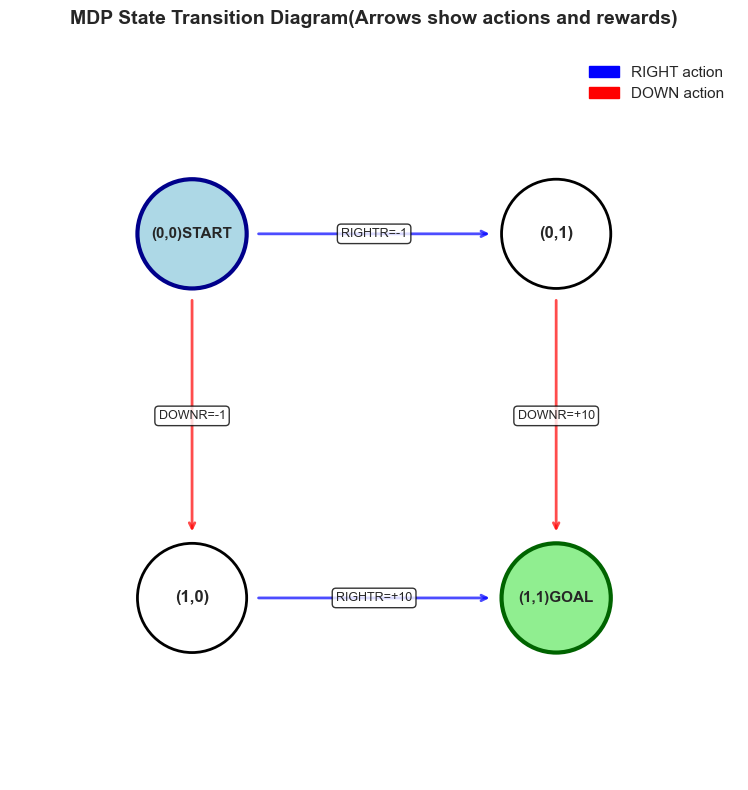

📊 Transition Diagram shows:
   - Blue arrows: RIGHT actions
   - Red arrows: DOWN actions
   - Labels show: Action name and Reward
   - Green circle: Goal state (1,1)
   - Blue circle: Start state (0,0)
This visualizes the complete MDP structure:
how states connect through actions and what rewards are received!


In [19]:
# Visualize the MDP as a state transition diagram
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_mdp_transitions(mdp):
    """Create a visualization of MDP state transitions."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define state positions for visualization
    state_positions = {
        '(0,0)': (1, 3),
        '(0,1)': (3, 3),
        '(1,0)': (1, 1),
        '(1,1)': (3, 1)
    }
    
    # Draw states
    for state, (x, y) in state_positions.items():
        if state == '(1,1)':
            # Goal state - green
            circle = plt.Circle((x, y), 0.3, color='lightgreen', ec='darkgreen', linewidth=3)
            ax.add_patch(circle)
            ax.text(x, y, state + 'GOAL', ha='center', va='center', 
                   fontsize=11, fontweight='bold')
        elif state == '(0,0)':
            # Start state - blue
            circle = plt.Circle((x, y), 0.3, color='lightblue', ec='darkblue', linewidth=3)
            ax.add_patch(circle)
            ax.text(x, y, state + 'START', ha='center', va='center', 
                   fontsize=11, fontweight='bold')
        else:
            # Regular state - white
            circle = plt.Circle((x, y), 0.3, color='white', ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y, state, ha='center', va='center', 
                   fontsize=12, fontweight='bold')
    
    # Draw transitions
    for (state, action), next_states in mdp.transitions.items():
        for next_state, prob in next_states.items():
            if state == next_state:
                # Self-loop (hitting wall or at goal)
                continue
            
            x1, y1 = state_positions[state]
            x2, y2 = state_positions[next_state]
            
            # Calculate arrow position
            dx = x2 - x1
            dy = y2 - y1
            length = np.sqrt(dx**2 + dy**2)
            
            # Normalize and shorten to account for circle radius
            dx_norm = dx / length
            dy_norm = dy / length
            
            start_x = x1 + dx_norm * 0.35
            start_y = y1 + dy_norm * 0.35
            end_x = x2 - dx_norm * 0.35
            end_y = y2 - dy_norm * 0.35
            
            # Get reward for this transition
            reward = mdp.get_reward(state, action, next_state)
            
            # Color based on action
            color = 'blue' if action == 'RIGHT' else 'red'
            
            # Draw arrow
            ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                       arrowprops=dict(arrowstyle='->', lw=2, color=color, alpha=0.7))
            
            # Add label
            mid_x = (start_x + end_x) / 2
            mid_y = (start_y + end_y) / 2
            label = f"{action}R={reward:+.0f}"
            ax.text(mid_x, mid_y, label, ha='center', va='center',
                   fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add legend
    right_patch = mpatches.Patch(color='blue', label='RIGHT action')
    down_patch = mpatches.Patch(color='red', label='DOWN action')
    ax.legend(handles=[right_patch, down_patch], loc='upper right', fontsize=11)
    
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('MDP State Transition Diagram(Arrows show actions and rewards)', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig, ax

# Create visualization
fig, ax = visualize_mdp_transitions(mdp)
plt.show()

print("📊 Transition Diagram shows:")
print("   - Blue arrows: RIGHT actions")
print("   - Red arrows: DOWN actions")
print("   - Labels show: Action name and Reward")
print("   - Green circle: Goal state (1,1)")
print("   - Blue circle: Start state (0,0)")
print("This visualizes the complete MDP structure:")
print("how states connect through actions and what rewards are received!")